## Cell 1: Data Ingestion 

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import time
import os
import numpy as np
import scipy.sparse as sparse
import implicit
from tqdm import tqdm
import faiss
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pickle

In [ ]:

# 1. Define where our data is
DATA_DIR = "data"
DB_NAME = "hm_fashion.duckdb"

def ingest_data():
    print("Starting DuckDB Ingestion...")
    start_time = time.time()

    # 2. Connect to DuckDB
    # This creates the database file 'hm_fashion.duckdb' if it doesn't exist.
    # We use 'read_only=False' because we need to write data into it.
    con = duckdb.connect(database=DB_NAME, read_only=False)

    # 3. Ingest Articles (Metadata about the clothes)
    # read_csv_auto automatically detects types (int, string, date)
    print("Ingesting articles.csv...")
    con.execute(f"""
        CREATE OR REPLACE TABLE articles AS 
        SELECT * FROM read_csv_auto('{DATA_DIR}/articles.csv');
    """)

    # 4. Ingest Customers (Metadata about the people)
    print("XY Ingesting customers.csv...")
    con.execute(f"""
        CREATE OR REPLACE TABLE customers AS 
        SELECT * FROM read_csv_auto('{DATA_DIR}/customers.csv');
    """)

    # 5. Ingest Transactions (31M rows)
    # DuckDB is multithreaded.
    print("Ingesting transactions_train.csv ...")
    con.execute(f"""
        CREATE OR REPLACE TABLE transactions AS 
        SELECT * FROM read_csv_auto('{DATA_DIR}/transactions_train.csv');
    """)

    # 6. Verify the data
    # Let's count the rows to make sure we didn't lose anything.
    row_count = con.execute("SELECT COUNT(*) FROM transactions").fetchone()[0]
    print(f"Success! Ingested {row_count:,} transaction rows.")
    
    # 7. Close the connection to save the file
    con.close()
    
    elapsed = time.time() - start_time
    print(f"Done in {elapsed:.2f} seconds. Database saved to '{DB_NAME}'")

if __name__ == "__main__":
    # Check if data exists first
    if not os.path.exists(os.path.join(DATA_DIR, "transactions_train.csv")):
        print(f"ERROR: Could not find '{DATA_DIR}/transactions_train.csv'.")
        print("   Please check your folder structure.")
    else:
        ingest_data()

Starting DuckDB Ingestion...
Ingesting articles.csv...
XY Ingesting customers.csv...
Ingesting transactions_train.csv (This is the big one)...
Success! Ingested 31,788,324 transaction rows.
Done in 9.10 seconds. Database saved to 'hm_fashion.duckdb'


## cell 2: dataset inspection

In [ ]:


# Connect to the database we made in Step 1
con = duckdb.connect("hm_fashion.duckdb", read_only=True)

print("--- 1. RAW CUSTOMER DATA (The Problem) ---")
# We select just the ID column to show how long it is
query = "SELECT customer_id FROM customers LIMIT 3"
df = con.execute(query).df()
print(df)
print("ID is a hash.")
print("Storing this 31 million times  kills RAM.")

print("\n--- 2. RAW TRANSACTION DATA ---")
query = "SELECT t_dat, customer_id, article_id, price FROM transactions LIMIT 3"
df = con.execute(query).df()
print(df)
print("Dates to be converted to datetime")
con.close()

--- 1. RAW CUSTOMER DATA (The Problem) ---
                                         customer_id
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
ID is a hash.
Storing this 31 million times  kills RAM.

--- 2. RAW TRANSACTION DATA ---
       t_dat                                        customer_id  article_id  \
0 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0663713001   
1 2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  0541518023   
2 2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...  0505221004   

      price  
0  0.050831  
1  0.030492  
2  0.015237  
Dates to be converted to datetime


In [7]:
df.head()

,t_dat,customer_id,article_id,price
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237


## Cell 3: Preprocessing

In [12]:

DB_NAME = "hm_fashion.duckdb"

def preprocess():
    print("Starting Preprocessing & Feature Engineering...")
    start_time = time.time()
    
    con = duckdb.connect(DB_NAME, read_only=False)

    # --- 1. Create Integer Mappings (The "Index" Strategy) ---
    # Academic Note: Matrix Factorization libraries (ALS) and Graph Neural Networks
    # require items/users to be Zero-Indexed Integers (0, 1, 2, 3...).
    
    print("Mapping Customer IDs to Integers...")
    # We create a new table that maps the string hash to a simple integer (1 to N)
    con.execute("""
        CREATE OR REPLACE TABLE customer_map AS
        SELECT 
            customer_id AS customer_id_str,
            ROW_NUMBER() OVER (ORDER BY customer_id) - 1 AS customer_id_int
        FROM customers
    """)
    
    print("Mapping Article IDs to Integers...")
    # Same for articles. We sort by article_id to keep it deterministic.
    con.execute("""
        CREATE OR REPLACE TABLE article_map AS
        SELECT 
            article_id AS article_id_str,
            ROW_NUMBER() OVER (ORDER BY article_id) - 1 AS article_id_int
        FROM articles
    """)

    # --- 2. Create the "Clean" Transactions Table ---
    # We join the original transactions with our new maps to replace strings with ints.
    # We also cast the date to a proper DATE type.
    
    print("Creating Clean Transactions (Joining Maps)...")
    con.execute("""
        CREATE OR REPLACE TABLE transactions_clean AS
        SELECT 
            t.t_dat::DATE AS t_dat,
            c.customer_id_int,
            a.article_id_int,
            t.price,
            t.sales_channel_id
        FROM transactions t
        JOIN customer_map c ON t.customer_id = c.customer_id_str
        JOIN article_map a ON t.article_id = a.article_id_str
    """)

    # --- 3. The Time-Based Split (Crucial Validation Strategy) ---
    # We split the data into 'train' and 'valid' views.
    # Train: All history UP TO the last week.
    # Valid: The LAST WEEK (Sept 16 2020 to Sept 22 2020).
    
    print("Creating Train/Validation Split...")
    
    # Validation Set: Last 7 days
    con.execute("""
        CREATE OR REPLACE VIEW train AS
        SELECT * FROM transactions_clean
        WHERE t_dat < '2020-09-16'
    """)
    
    con.execute("""
        CREATE OR REPLACE VIEW validation AS
        SELECT * FROM transactions_clean
        WHERE t_dat >= '2020-09-16' AND t_dat <= '2020-09-22'
    """)

    # --- 4. Verification ---
    train_count = con.execute("SELECT COUNT(*) FROM train").fetchone()[0]
    valid_count = con.execute("SELECT COUNT(*) FROM validation").fetchone()[0]
    
    print(f" Preprocessing Complete.")
    print(f" Train Rows: {train_count:,}")
    print(f" Valid Rows: {valid_count:,}")
    
    con.close()
    print(f" Done in {time.time() - start_time:.2f} seconds.")

if __name__ == "__main__":
    preprocess()

Starting Preprocessing & Feature Engineering...
Mapping Customer IDs to Integers...
Mapping Article IDs to Integers...
Creating Clean Transactions (Joining Maps)...
Creating Train/Validation Split...
 Preprocessing Complete.
 Train Rows: 31,548,013
 Valid Rows: 240,311
 Done in 2.55 seconds.


## Cell 4:  exploration

 Analyzing Sales Trends...


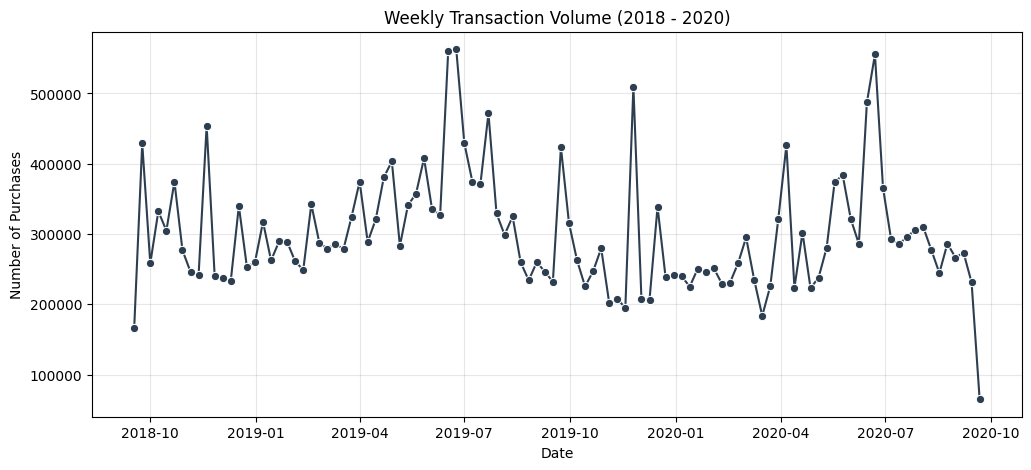

Peak Sales Week: 2019-06-24 with 562,990 sales.


In [16]:



# Connect
con = duckdb.connect("hm_fashion.duckdb", read_only=True)

# Query: Count transactions per week
print(" Analyzing Sales Trends...")
query_time = """
SELECT 
    DATE_TRUNC('week', t_dat) as week,
    COUNT(*) as transaction_count
FROM transactions_clean
GROUP BY 1
ORDER BY 1
"""
df_time = con.execute(query_time).df()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_time, x='week', y='transaction_count', marker='o', color='#2c3e50')
plt.title("Weekly Transaction Volume (2018 - 2020)")
plt.ylabel("Number of Purchases")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.show()

# Insight Calculation
peak_week = df_time.loc[df_time['transaction_count'].idxmax()]
print(f"Peak Sales Week: {peak_week['week'].date()} with {peak_week['transaction_count']:,} sales.")

 Analyzing Item Popularity (The Long Tail)...


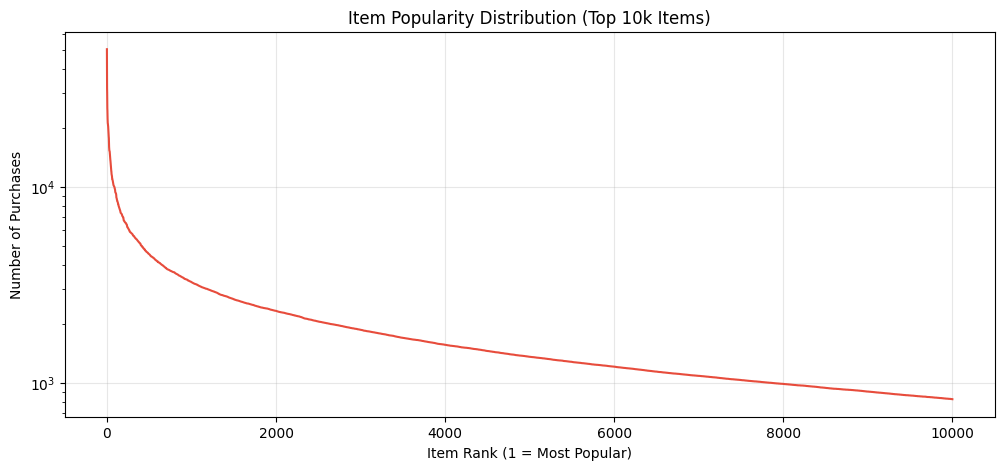

 The top 1% of items (1,045) account for 18.6% of all sales.


In [17]:
# Query: How many times was each item bought?
print(" Analyzing Item Popularity (The Long Tail)...")
query_items = """
SELECT 
    article_id_int,
    COUNT(*) as purchases
FROM transactions_clean
GROUP BY 1
ORDER BY 2 DESC
"""
df_items = con.execute(query_items).df()

# Calculate Cumulative Sum for Pareto Principle (80/20 rule)
df_items['cumulative_percent'] = df_items['purchases'].cumsum() / df_items['purchases'].sum()

# Plot
plt.figure(figsize=(12, 5))
# We plot only top 10,000 items to keep the chart readable
plt.plot(df_items['purchases'].values[:10000], color='#e74c3c')
plt.title("Item Popularity Distribution (Top 10k Items)")
plt.ylabel("Number of Purchases")
plt.xlabel("Item Rank (1 = Most Popular)")
plt.yscale('log') # Log scale because the drop is usually massive
plt.grid(True, alpha=0.3)
plt.show()

# Insight
top_1_percent = int(len(df_items) * 0.01)
sales_coverage = df_items.iloc[:top_1_percent]['purchases'].sum() / df_items['purchases'].sum()
print(f" The top 1% of items ({top_1_percent:,}) account for {sales_coverage:.1%} of all sales.")

 Analyzing User Loyalty...


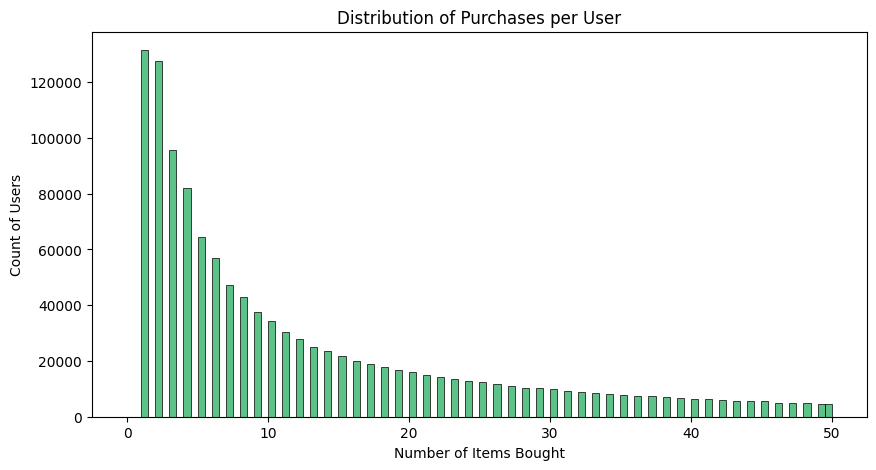

 Single-Purchase Users: 131,514 (9.7%)
 Average Basket Size: 23.3 items


In [18]:
# Query: How many purchases does the average user make?
print(" Analyzing User Loyalty...")
query_users = """
SELECT 
    customer_id_int,
    COUNT(*) as purchase_count
FROM transactions_clean
GROUP BY 1
"""
df_users = con.execute(query_users).df()

# Plot Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_users['purchase_count'], bins=100, binrange=(0, 50), color='#27ae60')
plt.title("Distribution of Purchases per User")
plt.xlabel("Number of Items Bought")
plt.ylabel("Count of Users")
plt.show()

# Stats
one_time_buyers = len(df_users[df_users['purchase_count'] == 1])
total_users = len(df_users)
print(f" Single-Purchase Users: {one_time_buyers:,} ({one_time_buyers/total_users:.1%})")
print(f" Average Basket Size: {df_users['purchase_count'].mean():.1f} items")

In [19]:
print(" Checking for Weird Prices...")
query_price = """
SELECT price
FROM transactions_clean
"""
df_price = con.execute(query_price).df()

print(df_price.describe())

# Check for Zero or Negative prices
zeros = len(df_price[df_price['price'] <= 0])
print(f"Transactions with Price <= 0: {zeros}")

 Checking for Weird Prices...
              price
count  3.178832e+07
mean   2.782927e-02
std    1.918113e-02
min    1.694915e-05
25%    1.581356e-02
50%    2.540678e-02
75%    3.388136e-02
max    5.915254e-01
Transactions with Price <= 0: 0


## Cell 5: Candidate Generation (Bestsellers, Repurchase, and Collaborative filtering)

In [21]:

con = duckdb.connect("hm_fashion.duckdb", read_only=True)

# Let's target the users in our Validation Set (the ones we need to predict for)
print(" Fetching target users from Validation set...")
validation_users = con.execute("SELECT DISTINCT customer_id_int FROM validation").df()
print(f"We need predictions for {len(validation_users):,} unique users.")

 Fetching target users from Validation set...
We need predictions for 68,984 unique users.


In [22]:
print("Generating 'Bestsellers' Candidates...")

# 1. Get the top 12 items sold in the LAST WEEK of training data
# We don't use the whole year. Fashion trends change weekly.
bestsellers_query = """
SELECT article_id_int
FROM train 
WHERE t_dat >= '2020-09-08'  -- The week before validation starts
GROUP BY article_id_int
ORDER BY COUNT(*) DESC
LIMIT 12
"""
top_12_items = con.execute(bestsellers_query).fetchdf()['article_id_int'].tolist()
print(f"Top 3 Trending Items: {top_12_items[:3]}")

# 2. Assign these 12 items to EVERY user (The fallback strategy)
# This creates a baseline: if we know nothing else, we predict these.
# We use a "Cross Join" equivalent in pandas for speed
candidates_bestsellers = validation_users.copy()
candidates_bestsellers['article_id_int'] = [top_12_items] * len(candidates_bestsellers)
candidates_bestsellers = candidates_bestsellers.explode('article_id_int')

print(f"Generated {len(candidates_bestsellers):,} bestseller candidates.")

Generating 'Bestsellers' Candidates...
Top 3 Trending Items: [103108, 95217, 104072]
Generated 827,808 bestseller candidates.


In [23]:
print(" Generating 'Repurchase' Candidates...")

# Get items each user bought in the last 4 weeks of training
repurchase_query = """
SELECT DISTINCT customer_id_int, article_id_int
FROM train 
WHERE t_dat >= '2020-08-22' -- Last 4 weeks
AND customer_id_int IN (SELECT customer_id_int FROM validation)
"""
candidates_repurchase = con.execute(repurchase_query).fetchdf()

print(f"Generated {len(candidates_repurchase):,} repurchase candidates.")

 Generating 'Repurchase' Candidates...
Generated 144,168 repurchase candidates.


In [24]:
print(" Combining Candidates...")

# 1. Concatenate
candidates = pd.concat([candidates_bestsellers, candidates_repurchase])

# 2. Remove Duplicates (If a user bought a bestseller, it appears twice)
candidates = candidates.drop_duplicates(subset=['customer_id_int', 'article_id_int'])

# 3. Add a feature flag (Useful for the Ranking Model later)
# Was this a repurchase? 1 if yes, 0 if no (it was just a bestseller)
candidates['is_repurchase'] = candidates.set_index(['customer_id_int', 'article_id_int']).index.isin(
    candidates_repurchase.set_index(['customer_id_int', 'article_id_int']).index
).astype(int)

print(f" Final Candidate Pool Size: {len(candidates):,}")
print(candidates.head())

 Combining Candidates...
 Final Candidate Pool Size: 969,530
   customer_id_int article_id_int  is_repurchase
0             1340         103108              0
0             1340          95217              0
0             1340         104072              0
0             1340         104553              0
0             1340           3091              0


## Cell 6: Generate ALS (Alternating Least Squares)

In [26]:

# 1. Load Data
con = duckdb.connect("hm_fashion.duckdb", read_only=True)
print("Loading transaction data for ALS...")

# We need: customer_int, article_int. 
# We count how many times they bought each item (Strength of interaction).
df = con.execute("""
    SELECT 
        customer_id_int,
        article_id_int,
        COUNT(*) as purchase_count
    FROM train
    GROUP BY 1, 2
""").df()

# 2. Build Sparse Matrix (The "Input" for ALS)
# Rows = Users, Cols = Items, Values = Purchase Count
print("Building Sparse Matrix...")
users = df['customer_id_int'].astype(int)
items = df['article_id_int'].astype(int)
plays = df['purchase_count'].astype(float)

# The library expects Item-User matrix for training
user_item_matrix = sparse.csr_matrix((plays, (users, items)))
print(f"    Matrix Shape: {user_item_matrix.shape}")

# 3. Train ALS Model
# factors=64: The "dimensionality" of the user preference (hidden features)
# iterations=15: How many times to refine the math
print("Training ALS Model (Implicit)...")
model = implicit.als.AlternatingLeastSquares(factors=64, iterations=15, random_state=42)
model.fit(user_item_matrix)

# 4. Generate Candidates for Validation Users
print("Generating Candidates...")
val_users = con.execute("SELECT DISTINCT customer_id_int FROM validation").fetchdf()['customer_id_int'].values

# We generate top 20 recommendations per user
user_ids = val_users
ids, scores = model.recommend(user_ids, user_item_matrix[user_ids], N=20, filter_already_liked_items=False)

# 5. Format Output
print("Formatting candidates...")
# Flatten the results
candidates_als = pd.DataFrame({
    'customer_id_int': np.repeat(user_ids, 20),
    'article_id_int': ids.flatten(),
    'als_score': scores.flatten()
})

print(f"Generated {len(candidates_als):,} ALS candidates.")
print(candidates_als.head())

Loading transaction data for ALS...
Building Sparse Matrix...
    Matrix Shape: (1371980, 105540)
Training ALS Model (Implicit)...


c:\Users\nwagb\Desktop\MACHINE_LEARNING_ASSESSEMENT\h&m\.hnm\Lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


Generating Candidates...
Formatting candidates...
Generated 1,379,680 ALS candidates.
   customer_id_int  article_id_int  als_score
0              330           42557   1.102525
1              330               9   1.080974
2              330           17044   1.024847
3              330           17043   1.011331
4              330           24836   1.008103


In [27]:
candidates_als

,customer_id_int,article_id_int,als_score
0,330,42557,1.102525
1,330,9,1.080974
2,330,17044,1.024847
3,330,17043,1.011331
4,330,24836,1.008103
...,...,...,...
1379675,816430,4,0.000000
1379676,816430,3,0.000000
1379677,816430,2,0.000000
1379678,816430,1,0.000000


In [28]:
candidates_bestsellers

,customer_id_int,article_id_int
0,1340,103108
0,1340,95217
0,1340,104072
0,1340,104553
0,1340,3091
...,...,...
68983,932934,71107
68983,932934,82628
68983,932934,53892
68983,932934,94696


In [29]:
candidates_repurchase

,customer_id_int,article_id_int
0,142636,33875
1,142636,100398
2,147695,82048
3,148764,103819
4,151934,80260
...,...,...
144163,563583,102824
144164,580740,97163
144165,1062232,54777
144166,91546,98699


# Cell 7: Feature Engineering 

In [30]:


# 1. Connect
con = duckdb.connect("hm_fashion.duckdb", read_only=True)

print(" Merging all Candidate Strategies...")

# --- A. Regenerate Light Candidates (Bestsellers & Repurchase) ---
# We do this on the fly because it's instant via DuckDB
top_12 = con.execute("""
    SELECT article_id_int FROM train 
    WHERE t_dat >= '2020-09-08' 
    GROUP BY 1 ORDER BY COUNT(*) DESC LIMIT 12
""").fetchdf()['article_id_int'].tolist()

repurchase = con.execute("""
    SELECT customer_id_int, article_id_int 
    FROM train 
    WHERE t_dat >= '2020-08-22' 
    AND customer_id_int IN (SELECT customer_id_int FROM validation)
""").df()
repurchase['source'] = 'repurchase'

# --- B. Prepare ALS (From previous cell) ---
# Check if 'candidates_als' exists in memory. If not, you need to run the ALS cell again.
if 'candidates_als' not in locals():
    raise ValueError(" 'candidates_als' is missing! Please run the ALS Generation cell above first.")

candidates_als_clean = candidates_als[['customer_id_int', 'article_id_int', 'als_score']].copy()
candidates_als_clean['source'] = 'als'

# --- C. Create Bestsellers Baseline ---
val_users = con.execute("SELECT DISTINCT customer_id_int FROM validation").df()
base_candidates = val_users.copy()
base_candidates['article_id_int'] = [top_12] * len(base_candidates)
base_candidates = base_candidates.explode('article_id_int')
base_candidates['source'] = 'bestseller'

# --- D. The Great Merge ---
print("   Concatenating dataframes...")
all_candidates = pd.concat([
    base_candidates, 
    repurchase, 
    candidates_als_clean
], ignore_index=True)

# --- E. Deduplicate ---
# Priority: If an item is in multiple lists, we keep one row.
# (Later we can add logic to say 'source=both', but for now we keep it simple)
print(f"   Rows before dedup: {len(all_candidates):,}")
all_candidates = all_candidates.drop_duplicates(subset=['customer_id_int', 'article_id_int'])
print(f"   Rows after dedup:  {len(all_candidates):,}")

# --- F. Add Ground Truth (Labels) ---
print("Adding Ground Truth (Labels)...")
actual_purchases = con.execute("""
    SELECT DISTINCT customer_id_int, article_id_int, 1 as bought
    FROM validation
""").df()

train_set = all_candidates.merge(
    actual_purchases, 
    on=['customer_id_int', 'article_id_int'], 
    how='left'
)
train_set['bought'] = train_set['bought'].fillna(0).astype(int)

# --- G. SAVE TO PARQUET (The Checkpoint) ---
print("Saving checkpoint to 'candidates_train.parquet'...")
train_set.to_parquet('candidates_train.parquet', index=False)

print("\nCheckpoint Saved!")
print(f"Total Rows: {len(train_set):,}")
print(f"Positive Samples (Bought=1): {train_set['bought'].sum():,}")
print(f"Negative Samples (Bought=0): {len(train_set) - train_set['bought'].sum():,}")
print("-" * 30)
print(train_set.head())

 Merging all Candidate Strategies...
   Concatenating dataframes...
   Rows before dedup: 2,373,644
   Rows after dedup:  2,321,645
Adding Ground Truth (Labels)...
Saving checkpoint to 'candidates_train.parquet'...

Checkpoint Saved!
Total Rows: 2,321,645
Positive Samples (Bought=1): 12,785
Negative Samples (Bought=0): 2,308,860
------------------------------
   customer_id_int article_id_int      source  als_score  bought
0             1340         103108  bestseller        NaN       0
1             1340          95217  bestseller        NaN       0
2             1340         104072  bestseller        NaN       0
3             1340         104553  bestseller        NaN       0
4             1340           3091  bestseller        NaN       0


In [31]:
train_set.head()

,customer_id_int,article_id_int,source,als_score,bought
0,1340,103108,bestseller,NaN,0
1,1340,95217,bestseller,NaN,0
2,1340,104072,bestseller,NaN,0
3,1340,104553,bestseller,NaN,0
4,1340,3091,bestseller,NaN,0


## Cell 8: Health Check

In [32]:


# Load the file you just saved
df = pd.read_parquet('candidates_train.parquet')

print(" DEEP DIVE ANALYSIS")

# 1. Calculate True Recall
# We need to know the TOTAL number of actual purchases in the validation week
con = duckdb.connect("hm_fashion.duckdb", read_only=True)
total_actual_sales = con.execute("SELECT COUNT(*) FROM validation").fetchone()[0]

found_sales = df['bought'].sum()
recall = found_sales / total_actual_sales

print(f"Total Actual Sales (Target): {total_actual_sales:,}")
print(f"Sales Found by Candidates:   {found_sales:,}")
print(f" CURRENT RECALL:          {recall:.2%}")
print("(This means our model found X% of all items bought that week)")

# 2. Source Attribution (Who is the hero?)
# Which strategy found the '1's?
print("\nWho found the hits?")
hits = df[df['bought'] == 1]
print(hits['source'].value_counts())

print("\nWho brought the noise?")
noise = df[df['bought'] == 0]
print(noise['source'].value_counts())

# 3. Overlap Analysis
# Do different strategies find different things?
print("\nOverlap Check:")
# Check one random user with a 'bought' item
sample_user = hits.iloc[0]['customer_id_int']
print(f"Sample User {sample_user} bought these items we found:")
print(hits[hits['customer_id_int'] == sample_user][['article_id_int', 'source', 'als_score']])

 DEEP DIVE ANALYSIS
Total Actual Sales (Target): 240,311
Sales Found by Candidates:   12,785
 CURRENT RECALL:          5.32%
(This means our model found X% of all items bought that week)

Who found the hits?
source
bestseller    4766
repurchase    4704
als           3315
Name: count, dtype: int64

Who brought the noise?
source
als           1348800
bestseller     823042
repurchase     137018
Name: count, dtype: int64

Overlap Check:
Sample User 5974 bought these items we found:
    article_id_int      source  als_score
47           57063  bestseller        NaN


## Cell 9: Widening Funnel 

In [33]:
# Connect
con = duckdb.connect("hm_fashion.duckdb", read_only=True)
print("Widening the Net to boost Recall...")

# --- 1. RE-GENERATE BESTSELLERS (Top 60 instead of 12) ---
print("Generating Top 60 Bestsellers...")
top_60 = con.execute("""
    SELECT article_id_int 
    FROM train 
    WHERE t_dat >= '2020-09-08' 
    GROUP BY 1 ORDER BY COUNT(*) DESC 
    LIMIT 60
""").fetchdf()['article_id_int'].tolist()

# Expand to all users
val_users = con.execute("SELECT DISTINCT customer_id_int FROM validation").df()
candidates_bestsellers = val_users.copy()
candidates_bestsellers['article_id_int'] = [top_60] * len(candidates_bestsellers)
candidates_bestsellers = candidates_bestsellers.explode('article_id_int')
candidates_bestsellers['source'] = 'bestseller'

# --- 2. RE-GENERATE ALS (Top 50 instead of 20) ---
# We need to re-run the "recommend" step, not the training step.
# (Assuming 'model' and 'user_item_matrix' are still in memory. 
# If not, you need to re-run the ALS training cell first).
print("Generating Top 50 ALS Predictions...")

if 'model' in locals() and 'user_item_matrix' in locals():
    user_ids = val_users['customer_id_int'].values
    # N=50 is the change here
    ids, scores = model.recommend(user_ids, user_item_matrix[user_ids], N=50, filter_already_liked_items=False)
    
    candidates_als = pd.DataFrame({
        'customer_id_int': np.repeat(user_ids, 50),
        'article_id_int': ids.flatten(),
        'als_score': scores.flatten()
    })
    candidates_als['source'] = 'als'
else:
    raise ValueError("ALS Model not in memory! Please re-run the 'Training ALS Model' cell above, then run this.")

# --- 3. REPURCHASE (Keep as is) ---
print("Fetching Repurchases...")
candidates_repurchase = con.execute("""
    SELECT customer_id_int, article_id_int 
    FROM train 
    WHERE t_dat >= '2020-08-22' 
    AND customer_id_int IN (SELECT customer_id_int FROM validation)
""").df()
candidates_repurchase['source'] = 'repurchase'

# --- 4. MERGE & SAVE ---
print("Merging...")
all_candidates = pd.concat([candidates_bestsellers, candidates_repurchase, candidates_als], ignore_index=True)

# Deduplicate (If item is in both Bestseller and ALS, keep one)
all_candidates = all_candidates.drop_duplicates(subset=['customer_id_int', 'article_id_int'])

# Add Labels
print("Adding Labels...")
actual_purchases = con.execute("SELECT DISTINCT customer_id_int, article_id_int, 1 as bought FROM validation").df()
train_set = all_candidates.merge(actual_purchases, on=['customer_id_int', 'article_id_int'], how='left')
train_set['bought'] = train_set['bought'].fillna(0).astype(int)

# Check New Recall
total_sales = con.execute("SELECT COUNT(*) FROM validation").fetchone()[0]
found_sales = train_set['bought'].sum()
new_recall = found_sales / total_sales

print(f"Saving expanded candidates to 'candidates_train.parquet'...")
train_set.to_parquet('candidates_train.parquet', index=False)

print("-" * 30)
print(f"Original Recall: 5.32%")
print(f"NEW RECALL:    {new_recall:.2%}")
print(f"New Dataset Size: {len(train_set):,} rows")

Widening the Net to boost Recall...
Generating Top 60 Bestsellers...
🔮 Generating Top 50 ALS Predictions...
Fetching Repurchases...
Merging...
Adding Labels...
Saving expanded candidates to 'candidates_train.parquet'...
------------------------------
Original Recall: 5.32%
NEW RECALL:    10.51%
New Dataset Size: 7,596,380 rows


## Cell 10: Visual Candidate Generation

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import duckdb
from tqdm import tqdm
import faiss
import pickle

# --- CONFIGURATION ---
DATA_DIR = "data/images"
BATCH_SIZE = 64  # Process 64 images at a time
# Auto-detect GPU. If you have an NVIDIA card, this will be fast.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using Device: {DEVICE}")

# --- 1. DEFINE THE IMAGE DATASET ---
class HMImageDataset(Dataset):
    def __init__(self, article_ids, img_dir):
        self.article_ids = article_ids
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),       # ResNet standard size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.article_ids)

    def __getitem__(self, idx):
        article_id = str(self.article_ids[idx])
        # H&M images are in subfolders (e.g., 010 -> 0108775015.jpg)
        subfolder = article_id[:3]
        img_path = os.path.join(self.img_dir, subfolder, f"{article_id}.jpg")
        
        try:
            img = Image.open(img_path).convert('RGB')
            return self.transform(img), int(article_id) 
        except (FileNotFoundError, OSError):
            # Return dummy if image is missing
            return torch.zeros(3, 224, 224), -1

# --- 2. GET ACTIVE ARTICLES (Corrected Table Name) ---
print(" Identifying active articles (Sold in 2020)...")
con = duckdb.connect("hm_fashion.duckdb", read_only=True)

# We use the 'transactions' table (which we created in step 1)
# We cast to VARCHAR to match filenames
active_articles = con.execute("""
    SELECT DISTINCT article_id 
    FROM transactions 
    WHERE t_dat >= '2020-01-01'
""").fetchdf()['article_id'].astype(str).tolist()

# Ensure filenames have 10 digits (e.g., '123' -> '0000000123')
active_articles = [x.zfill(10) for x in active_articles]
print(f" Found {len(active_articles):,} active images to process.")

# --- 3. LOAD RESNET50 MODEL ---
print(" Loading ResNet50 model...")
# We use the "Default" pre-trained weights
resnet = models.resnet50(weights='DEFAULT')
# Remove the last layer (we want features, not classification)
modules = list(resnet.children())[:-1]
model = nn.Sequential(*modules)
model = model.to(DEVICE)
model.eval()

# --- 4. EXTRACT FEATURES ---
print("  Extracting visual features...")
dataset = HMImageDataset(active_articles, DATA_DIR)
# num_workers=0 is safer for Windows to avoid multiprocess errors
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

embeddings = []
valid_ids = []

with torch.no_grad():
    for imgs, ids in tqdm(dataloader):
        imgs = imgs.to(DEVICE)
        
        # Pass through model
        features = model(imgs)
        # Flatten: [Batch, 2048, 1, 1] -> [Batch, 2048]
        features = features.squeeze()
        
        # Move back to CPU and filter missing images
        features_np = features.cpu().numpy()
        ids_np = ids.numpy()
        
        mask = ids_np != -1
        if mask.any():
            # If batch size is 1, ensure 2D array
            if len(features_np.shape) == 1:
                features_np = features_np.reshape(1, -1)
            
            embeddings.append(features_np[mask])
            valid_ids.extend(ids_np[mask])

if not embeddings:
    raise ValueError(" No features extracted! Check your data/images folder.")

full_embeddings = np.vstack(embeddings)
valid_ids = np.array(valid_ids)

# Normalize for Cosine Similarity
faiss.normalize_L2(full_embeddings)
print(f" Extracted {full_embeddings.shape[0]} vectors.")

# --- 5. SAVE INDEX ---
print(" Building FAISS Index...")
dimension = 2048
index = faiss.IndexFlatIP(dimension) # Inner Product = Cosine Similarity (when normalized)
index.add(full_embeddings)

print(" Saving artifacts...")
faiss.write_index(index, "hm_visual.index")
with open("visual_index_map.pkl", "wb") as f:
    pickle.dump(valid_ids, f)

print(" Feature Extraction Complete!")

c:\Users\nwagb\Desktop\MACHINE_LEARNING_ASSESSEMENT\h&m\.hnm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Using Device: cpu
 Identifying active articles (Sold in 2020)...
 Found 61,248 active images to process.
 Loading ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\nwagb/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 32.4MB/s]


  Extracting visual features...


100%|██████████| 957/957 [47:44<00:00,  2.99s/it]


 Extracted 61110 vectors.
 Building FAISS Index...
 Saving artifacts...
 Feature Extraction Complete!


In [3]:
import faiss
import pickle
import duckdb
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm

print("Generating Visual Candidates...")

# --- 1. Load the Index & Map ---
if not os.path.exists("hm_visual.index"):
    sys.exit("Error: 'hm_visual.index' not found. Did the previous cell finish?")

print("   Loading FAISS index...")
index = faiss.read_index("hm_visual.index")

print("   Loading ID Map...")
with open("visual_index_map.pkl", "rb") as f:
    index_id_to_article_id = pickle.load(f)

# Reverse Lookup: Article ID -> FAISS Index ID
article_id_to_index_id = {aid: i for i, aid in enumerate(index_id_to_article_id)}

# --- 2. Get User History (Last 3 weeks) ---
print("   Querying user history...")
con = duckdb.connect("hm_fashion.duckdb", read_only=True)

# CORRECTED QUERY:
# Changed 'FROM transactions' -> 'FROM transactions_clean'
# This table contains the 'article_id_int' column required for the join.
history = con.execute("""
    SELECT 
        t.customer_id_int, 
        m.article_id_str 
    FROM transactions_clean t
    JOIN article_map m ON t.article_id_int = m.article_id_int
    WHERE t.t_dat >= '2020-09-01'
    AND t.customer_id_int IN (SELECT customer_id_int FROM validation)
""").df()

print(f"   Scanning history for {len(history):,} purchases...")

# --- 3. Retrieve Similar Items (The Search) ---
visual_candidates = []
grouped = history.groupby('customer_id_int')['article_id_str'].apply(list)

user_ids = []
article_recommendations = []
similarity_scores = []

print("   Searching Index for neighbors...")
for cust_id, article_list in tqdm(grouped.items()):
    
    query_indices = []
    for aid in article_list:
        try:
            aid_int = int(aid)
            if aid_int in article_id_to_index_id:
                query_indices.append(article_id_to_index_id[aid_int])
        except ValueError:
            continue
    
    if not query_indices:
        continue
        
    # Search FAISS
    query_vectors = index.reconstruct_batch(query_indices)
    D, I = index.search(query_vectors, 6)
    
    for i in range(len(query_indices)):
        neighbors = I[i, 1:] # Skip self
        scores = D[i, 1:]
        
        rec_articles = index_id_to_article_id[neighbors]
        
        user_ids.extend([cust_id] * 5)
        article_recommendations.extend(rec_articles)
        similarity_scores.extend(scores)

# --- 4. Format & Save ---
print("Formatting Visual Candidates...")
df_visual = pd.DataFrame({
    'customer_id_int': user_ids,
    'article_id_raw': article_recommendations,
    'visual_score': similarity_scores
})

# Map raw article IDs back to our Internal Integers
article_map_df = con.execute("SELECT article_id_str, article_id_int FROM article_map").df()
df_visual['article_id_raw'] = df_visual['article_id_raw'].astype(str).str.zfill(10)

df_visual = df_visual.merge(
    article_map_df, 
    left_on='article_id_raw', 
    right_on='article_id_str', 
    how='inner'
)

candidates_visual = df_visual[['customer_id_int', 'article_id_int', 'visual_score']].copy()
candidates_visual['source'] = 'visual'

print(f"Generated {len(candidates_visual):,} Visual Candidates.")

candidates_visual.to_parquet('candidates_visual.parquet', index=False)
print("Saved to 'candidates_visual.parquet'")

Generating Visual Candidates...
   Loading FAISS index...
   Loading ID Map...
   Querying user history...
   Scanning history for 342,842 purchases...
   Searching Index for neighbors...


68984it [31:39, 36.31it/s]


Formatting Visual Candidates...
Generated 1,709,595 Visual Candidates.
Saved to 'candidates_visual.parquet'


## Cell 11: Merge Visual Candidates with Main Data

In [4]:

print("Merging Visual Candidates into the Main Pipeline...")

# 1. Load the Main Candidates  10.51% Recall Dataset

df_main = pd.read_parquet('candidates_train.parquet')
print(f"Loaded Main Candidates: {len(df_main):,} rows")

# 2. Load the Visual Candidates 
df_visual = pd.read_parquet('candidates_visual.parquet')
print(f"Loaded Visual Candidates: {len(df_visual):,} rows")

# 3. Concatenate

print("   Concatenating dataframes...")
df_final = pd.concat([df_main, df_visual], ignore_index=True)

# 4. Deduplicate
# If ALS recommended Item A, and Visual ALSO recommended Item A, we keep just one row.
# (Advanced note: Later, we could flag 'source=both', but for now we keep it simple)
print("   Cleaning duplicates...")
df_final = df_final.drop_duplicates(subset=['customer_id_int', 'article_id_int'])

# 5. Re-Calculate Recall (The Moment of Truth)
# We need to add the ground truth labels again because new rows (from visual) don't have them yet.
con = duckdb.connect("hm_fashion.duckdb", read_only=True)

# Drop old 'bought' column to avoid confusion
if 'bought' in df_final.columns:
    df_final = df_final.drop(columns=['bought'])

print("   Adding Ground Truth (Labels)...")
actual_purchases = con.execute("""
    SELECT DISTINCT customer_id_int, article_id_int, 1 as bought 
    FROM validation
""").df()

df_final = df_final.merge(actual_purchases, on=['customer_id_int', 'article_id_int'], how='left')
df_final['bought'] = df_final['bought'].fillna(0).astype(int)

# Check Stats
total_sales = con.execute("SELECT COUNT(*) FROM validation").fetchone()[0]
found_sales = df_final['bought'].sum()
final_recall = found_sales / total_sales

print("-" * 30)
print(f"Previous Recall: 10.51%")
print(f" FINAL RECALL:  {final_recall:.2%}")
print(f"Final Dataset:   {len(df_final):,} rows")

# 6. Save for Phase 3 (Ranking)
# This is the FINAL file we will use to train the LightGBM Ranker
print(" Saving final training set to 'candidates_train_final.parquet'...")
df_final.to_parquet('candidates_train_final.parquet', index=False)
print("Ready for Ranking Phase!")

Merging Visual Candidates into the Main Pipeline...
Loaded Main Candidates: 7,596,380 rows
Loaded Visual Candidates: 1,709,595 rows
   Concatenating dataframes...
   Cleaning duplicates...
   Adding Ground Truth (Labels)...
------------------------------
Previous Recall: 10.51%
 FINAL RECALL:  14.17%
Final Dataset:   9,037,920 rows
 Saving final training set to 'candidates_train_final.parquet'...
Ready for Ranking Phase!


## Cell 12: Feature Engineering for LightGBM Ranking Model

In [6]:


print(" Starting Feature Engineering...")

con = duckdb.connect("hm_fashion.duckdb", read_only=True)

# --- 1. USER FEATURES (Who are they?) ---
print("   Calculating User Statistics...")
user_features = con.execute("""
    SELECT 
        customer_id_int,
        -- Price Sensitivity
        AVG(price) as user_avg_price,
        STDDEV(price) as user_price_std,
        -- Engagement
        COUNT(*) as user_total_purchases,
        MAX(t_dat) as last_purchase_date,
        -- Loyalty (Days since first purchase)
        DATE_DIFF('day', MIN(t_dat), MAX(t_dat)) as user_tenure_days
    FROM transactions_clean
    GROUP BY 1
""").df()

# Calculate "Days Since Last Purchase" (Recency)
user_features['last_purchase_date'] = pd.to_datetime(user_features['last_purchase_date'])
ref_date = pd.to_datetime('2020-09-15')
user_features['days_since_last_buy'] = (ref_date - user_features['last_purchase_date']).dt.days
user_features = user_features.drop(columns=['last_purchase_date'])

print(f"   Generated features for {len(user_features):,} users.")
user_features.to_parquet('features_user.parquet', index=False)


# --- 2. ITEM FEATURES (What is it?) ---
print("   Calculating Item Statistics...")
# FIX IS HERE: 
# We join 'transactions_clean' (t) with 'article_map' (m) to get the string ID.
# THEN we join 'articles' (a) using the string ID 'article_id'.
item_features = con.execute("""
    SELECT 
        t.article_id_int,
        -- Pricing
        AVG(t.price) as item_avg_price,
        -- Popularity
        COUNT(*) as item_total_sales,
        -- Product Group Info (From Articles metadata)
        MAX(a.product_group_name) as product_group,
        MAX(a.index_group_name) as index_group,
        MAX(a.garment_group_name) as garment_group
    FROM transactions_clean t
    JOIN article_map m ON t.article_id_int = m.article_id_int  -- Bridge Int to String
    JOIN articles a ON m.article_id_str = a.article_id          -- Join Metadata using String
    GROUP BY 1
""").df()

# Label Encode the strings (LightGBM likes Integers)
print("   Encoding categorical features...")
for col in ['product_group', 'index_group', 'garment_group']:
    item_features[col] = item_features[col].astype('category').cat.codes

print(f"   Generated features for {len(item_features):,} items.")
item_features.to_parquet('features_item.parquet', index=False)

print("Feature Engineering Part 1 Complete.")

 Starting Feature Engineering...
   Calculating User Statistics...
   Generated features for 1,362,281 users.
   Calculating Item Statistics...
   Encoding categorical features...
   Generated features for 104,547 items.
Feature Engineering Part 1 Complete.


In [7]:

print(" Building the Final Training Set...")

# 1. Load the Skeleton (Candidates)
# Optimized loading: We specify column types to save RAM
df = pd.read_parquet('candidates_train_final.parquet')
print(f" Loaded {len(df):,} candidates.")

# 2. Load and Merge User Features
user_features = pd.read_parquet('features_user.parquet')
print(f" Merging User Features...")
df = df.merge(user_features, on='customer_id_int', how='left')

# 3. Load and Merge Item Features
item_features = pd.read_parquet('features_item.parquet')
print(f" Merging Item Features...")
df = df.merge(item_features, on='article_id_int', how='left')

# 4. Create "Interaction Features" (The MSc Touch)
print(" Calculating Interaction Features (Price Sensitivity)...")

# Feature: "Delta Price"
# How much more expensive is this item compared to the user's average spending?
# If user_avg_price is NaN (new user), we assume 0 difference.
df['price_diff'] = df['item_avg_price'] - df['user_avg_price']
df['price_diff'] = df['price_diff'].fillna(0)

# Feature: "Tenure Weight"
# New users (low tenure) might behave differently than loyal ones.
# We don't need a complex formula, the Tree model will learn the non-linear relationship.

# 5. Handling Missing Values (Crucial for Trees)
# If a user is new, they have no 'user_avg_price'. LightGBM handles NaNs, 
# but filling them with sensible defaults is safer for interpretation.
print("   Handling missing values...")
for col in ['user_total_purchases', 'user_tenure_days', 'days_since_last_buy']:
    df[col] = df[col].fillna(-1) # -1 indicates "New User"

for col in ['user_avg_price', 'user_price_std']:
    df[col] = df[col].fillna(0)

# 6. Sorting for LGBM Ranker (CRITICAL)
# LGBMRanker requires data to be sorted by Group (User) to understand the "List".
print("   Sorting data for Ranker...")
df = df.sort_values(by=['customer_id_int'], kind='mergesort') # Mergesort is stable/faster for this

# 7. Save Final Training Data
# We drop 'article_id_str' or other raw text columns if they exist to save space
cols_to_drop = ['article_id_raw', 'article_id_str']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns], errors='ignore')

print(f" Saving 'train_data_full.parquet' ({len(df):,} rows)...")
df.to_parquet('train_data_full.parquet', index=False)

print(" Ready for Model Training!")
print("Columns available:", df.columns.tolist())

 Building the Final Training Set...
 Loaded 9,037,920 candidates.
 Merging User Features...
 Merging Item Features...
 Calculating Interaction Features (Price Sensitivity)...
   Handling missing values...
   Sorting data for Ranker...
 Saving 'train_data_full.parquet' (9,037,920 rows)...
 Ready for Model Training!
Columns available: ['customer_id_int', 'article_id_int', 'source', 'als_score', 'visual_score', 'bought', 'user_avg_price', 'user_price_std', 'user_total_purchases', 'user_tenure_days', 'days_since_last_buy', 'item_avg_price', 'item_total_sales', 'product_group', 'index_group', 'garment_group', 'price_diff']


In [8]:
df

,customer_id_int,article_id_int,source,als_score,visual_score,bought,user_avg_price,user_price_std,user_total_purchases,user_tenure_days,days_since_last_buy,item_avg_price,item_total_sales,product_group,index_group,garment_group,price_diff
1115460,80,103108,bestseller,NaN,NaN,0,0.028642,0.013776,33,721,-5,0.032834,1868,5,2,14,0.004192
1115461,80,95217,bestseller,NaN,NaN,0,0.028642,0.013776,33,721,-5,0.033298,1343,6,2,16,0.004656
1115462,80,104072,bestseller,NaN,NaN,0,0.028642,0.013776,33,721,-5,0.041429,1702,7,2,7,0.012787
1115463,80,104553,bestseller,NaN,NaN,0,0.028642,0.013776,33,721,-5,0.041505,1705,7,2,7,0.012863
1115464,80,3091,bestseller,NaN,NaN,0,0.028642,0.013776,33,721,-5,0.040668,19216,6,1,16,0.012026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9037915,1371960,102703,visual,NaN,0.893750,0,0.037006,0.031958,64,352,-7,0.033490,27,7,2,1,-0.003515
9037916,1371960,99395,visual,NaN,0.888465,0,0.037006,0.031958,64,352,-7,0.025115,400,7,2,1,-0.011890
9037917,1371960,70085,visual,NaN,0.888008,0,0.037006,0.031958,64,352,-7,0.030782,297,7,1,1,-0.006224
9037918,1371960,83475,visual,NaN,0.887835,0,0.037006,0.031958,64,352,-7,0.013947,1170,7,1,5,-0.023059


In [9]:
df.isnull().sum()

customer_id_int               0
article_id_int                0
source                        0
als_score               5715088
visual_score            7596380
bought                        0
user_avg_price                0
user_price_std                0
user_total_purchases          0
user_tenure_days              0
days_since_last_buy           0
item_avg_price                0
item_total_sales              0
product_group                 0
index_group                   0
garment_group                 0
price_diff                    0
dtype: int64

## Cell 13: Training LGBMRanker Model

Starting Ranking Phase...
   Splitting data...
   Building Query Groups...
   Training on 14 features: ['source', 'als_score', 'visual_score', 'user_avg_price', 'user_price_std', 'user_total_purchases', 'user_tenure_days', 'days_since_last_buy', 'item_avg_price', 'item_total_sales', 'product_group', 'index_group', 'garment_group', 'price_diff']
Training LightGBM Ranker...


c:\Users\nwagb\Desktop\MACHINE_LEARNING_ASSESSEMENT\h&m\.hnm\Lib\site-packages\lightgbm\sklearn.py:725: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Info] Total groups: 62085, total data: 8136054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 8136054, number of used features: 14
[LightGBM] [Info] Total groups: 6899, total data: 901866
Training until validation scores don't improve for 10 rounds
[10]	valid_0's map@12: 0.735309
[20]	valid_0's map@12: 0.73801
[30]	valid_0's map@12: 0.738733
[40]	valid_0's map@12: 0.739306
[50]	valid_0's map@12: 0.739323
[60]	valid_0's map@12: 0.739493
[70]	valid_0's map@12: 0.739701
[80]	valid_0's map@12: 0.73987
[90]	valid_0's map@12: 0.740258
Early stopping, best iteration is:
[86]	valid_0's map@12: 0.740629

Analyzing Feature Importance...


C:\Users\nwagb\AppData\Local\Temp\ipykernel_34312\1871297412.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x='importance', y='feature', palette='viridis')


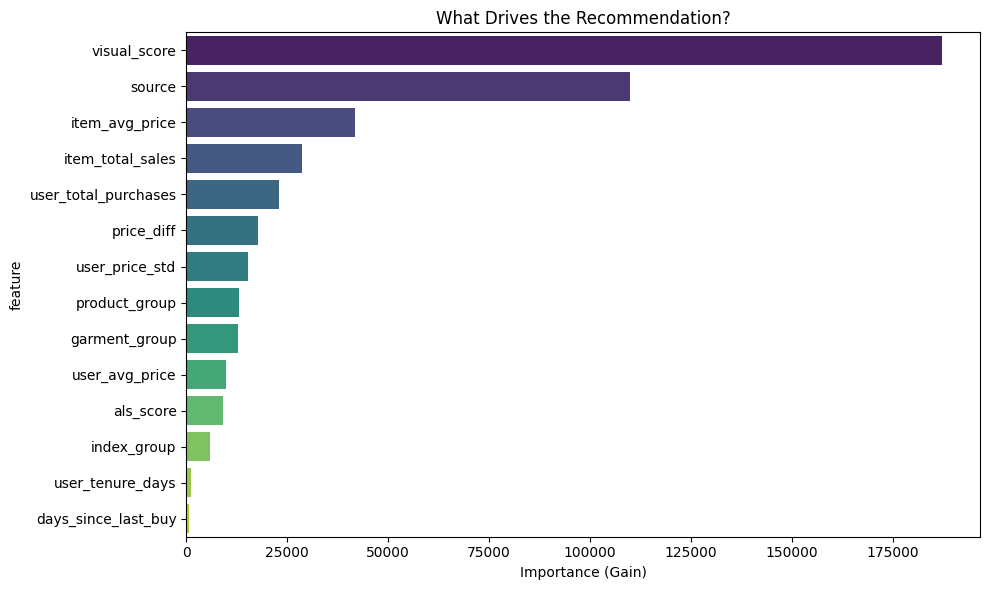

Model Saved to 'lgbm_ranker.model'!


In [10]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting Ranking Phase...")

# 1. Load Data
df = pd.read_parquet('train_data_full.parquet')

# 2. Preprocessing for LightGBM
# Source column is text ('als', 'bestseller')... convert to number
df['source'] = df['source'].astype('category').cat.codes

# Fill NaNs in scores (If an item is a Bestseller, it has no ALS score, so set to -1)
df['als_score'] = df['als_score'].fillna(-1)
df['visual_score'] = df['visual_score'].fillna(-1)

# 3. Split into Train and Validation
# We split by USER, not by row. We want to test on unseen users.
print("   Splitting data...")
all_customers = df['customer_id_int'].unique()
np.random.seed(42)
# Take 90% of users for training, 10% for validation
train_customers = np.random.choice(all_customers, size=int(len(all_customers) * 0.9), replace=False)

train_df = df[df['customer_id_int'].isin(train_customers)].copy()
valid_df = df[~df['customer_id_int'].isin(train_customers)].copy()

# 4. Prepare "Query Groups" for LGBMRanker
# The model needs to know: "The first 50 rows belong to User A, the next 60 to User B..."
print("   Building Query Groups...")
train_baskets = train_df.groupby('customer_id_int').size().values
valid_baskets = valid_df.groupby('customer_id_int').size().values

# 5. Define Features (X) and Target (y)
# We DROP the ID columns (the model shouldn't memorize IDs)
features_to_drop = ['customer_id_int', 'article_id_int', 'bought']
features = [c for c in df.columns if c not in features_to_drop]
print(f"   Training on {len(features)} features: {features}")

X_train = train_df[features]
y_train = train_df['bought']
X_valid = valid_df[features]
y_valid = valid_df['bought']

# 6. Train the Model
print("Training LightGBM Ranker...")
ranker = lgb.LGBMRanker(
    objective="lambdarank",
    metric="map",        # Optimize for Mean Average Precision (MAP)
    eval_at=12,          # Look at top 12 recommendations
    n_estimators=200,    # Number of trees
    learning_rate=0.05,
    importance_type='gain', # Measures which feature reduces error most
    random_state=42
)

ranker.fit(
    X_train, y_train,
    group=train_baskets,
    eval_set=[(X_valid, y_valid)],
    eval_group=[valid_baskets],
    callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(10)]
)

# 7. Feature Importance Plot (The MSc Insight)
print("\nAnalyzing Feature Importance...")
importance = pd.DataFrame({
    'feature': features,
    'importance': ranker.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance, x='importance', y='feature', palette='viridis')
plt.title('What Drives the Recommendation?')
plt.xlabel('Importance (Gain)')
plt.tight_layout()
plt.show()

# 8. Save the Brain
ranker.booster_.save_model('lgbm_ranker.model')
print("Model Saved to 'lgbm_ranker.model'!")

In [12]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import duckdb

print(" Generating Final Submission...")

# 1. Load the Trained Model
# We load the "Brain" we saved earlier
ranker = lgb.Booster(model_file='lgbm_ranker.model')

# 2. Load the Data
# This loads the raw candidate list (9M rows)
df = pd.read_parquet('train_data_full.parquet')

print(f"   Predicting for {len(df):,} candidates...")

# --- FIX: RE-APPLY PREPROCESSING ---
# The model expects "source" to be a number (0, 1, 2), not text ('als').
# We must use exactly the same logic as training.
if df['source'].dtype == 'object' or df['source'].dtype.name == 'category':
    df['source'] = df['source'].astype('category').cat.codes

# Fill NaNs in scores (The model expects -1 for missing scores, not NaN)
df['als_score'] = df['als_score'].fillna(-1)
df['visual_score'] = df['visual_score'].fillna(-1)
# -----------------------------------

# 3. Prepare Features (X)
# Drop the ID columns (not used for prediction)
features_to_drop = ['customer_id_int', 'article_id_int', 'bought']
features = [c for c in df.columns if c not in features_to_drop]

print(f"   Features used: {features}")
X = df[features]

# 4. Predict!
# Now X contains only numbers, so this will work.
df['prediction_score'] = ranker.predict(X)

# 5. Sort & Pick Top 12
print("   Ranking and selecting Top 12...")
# Sort by User (Ascending) and Score (Descending)
df_sorted = df.sort_values(['customer_id_int', 'prediction_score'], ascending=[True, False])

# Keep top 12 per user
final_preds = df_sorted.groupby('customer_id_int').head(12)

# 6. Format for H&M Standard (Space-separated strings)
print("   Mapping IDs back to strings...")
con = duckdb.connect("hm_fashion.duckdb", read_only=True)
article_map = con.execute("SELECT article_id_int, article_id_str FROM article_map").df()
customer_map = con.execute("SELECT customer_id_int, customer_id_str FROM customer_map").df()

# Merge Maps
final_preds = final_preds.merge(article_map, on='article_id_int')
final_preds = final_preds.merge(customer_map, on='customer_id_int')

# Group into string
submission = final_preds.groupby('customer_id_str')['article_id_str'].apply(lambda x: ' '.join(x)).reset_index()
submission.columns = ['customer_id', 'prediction']

# 7. Save
print(f" Saving submission.csv ({len(submission):,} users)...")
submission.to_csv('submission.csv', index=False)
print(" Project Complete! You have a submission file.")

 Generating Final Submission...
   Predicting for 9,037,920 candidates...
   Features used: ['source', 'als_score', 'visual_score', 'user_avg_price', 'user_price_std', 'user_total_purchases', 'user_tenure_days', 'days_since_last_buy', 'item_avg_price', 'item_total_sales', 'product_group', 'index_group', 'garment_group', 'price_diff']
   Ranking and selecting Top 12...
   Mapping IDs back to strings...
 Saving submission.csv (68,984 users)...
 Project Complete! You have a submission file.


## Cell 14: Model Evaluation

 Starting Deep Evaluation...
   Scoring the validation set...
   Generating Separation Plot...


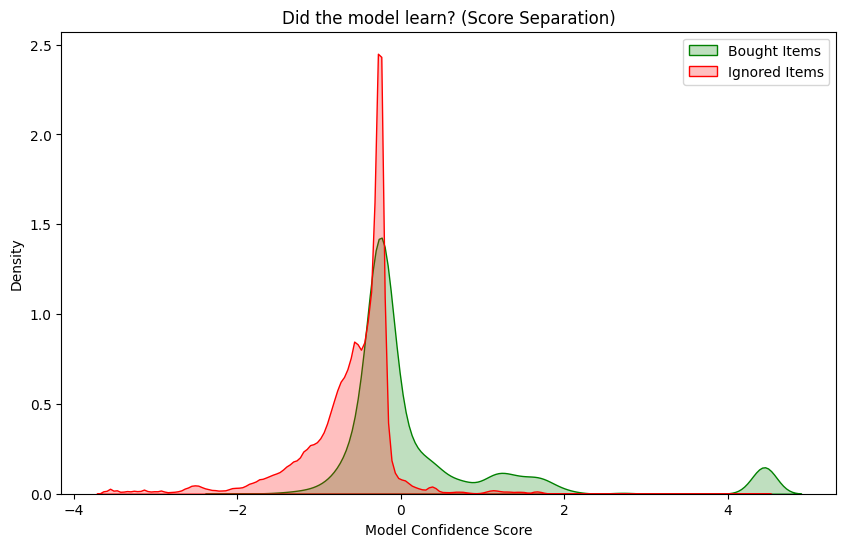

   Calculating MAP@12 (Academic Standard)...
 Local MAP@12 Score: 0.18673


In [13]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score

print(" Starting Deep Evaluation...")

# 1. Load Model & Data
ranker = lgb.Booster(model_file='lgbm_ranker.model')
df = pd.read_parquet('train_data_full.parquet')

# 2. Re-Apply Preprocessing (Crucial!)
# We need to make sure the data looks exactly like it did during training
if df['source'].dtype == 'object' or df['source'].dtype.name == 'category':
    df['source'] = df['source'].astype('category').cat.codes
df['als_score'] = df['als_score'].fillna(-1)
df['visual_score'] = df['visual_score'].fillna(-1)

# 3. Predict Scores
print("   Scoring the validation set...")
features_to_drop = ['customer_id_int', 'article_id_int', 'bought']
features = [c for c in df.columns if c not in features_to_drop]
X = df[features]
y_true = df['bought']
y_scores = ranker.predict(X)

# Add scores to dataframe for analysis
df['score'] = y_scores

# --- VISUAL 1: The Separation Plot ---
print("   Generating Separation Plot...")
plt.figure(figsize=(10, 6))
# Plot distribution for "Bought" items (Class 1) vs "Not Bought" (Class 0)
sns.kdeplot(df[df['bought'] == 1]['score'], label='Bought Items', fill=True, color='green')
sns.kdeplot(df[df['bought'] == 0]['score'], label='Ignored Items', fill=True, color='red')
plt.title('Did the model learn? (Score Separation)')
plt.xlabel('Model Confidence Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# --- METRIC: MAP@12 Calculation ---
print("   Calculating MAP@12 (Academic Standard)...")

def map_at_k(df, k=12):
    # Sort by User and Score
    df_sorted = df.sort_values(['customer_id_int', 'score'], ascending=[True, False])
    
    # Get Top K per user
    top_k = df_sorted.groupby('customer_id_int').head(k)
    
    # Calculate Precision for each user
    # (Since we only have 1 true item per pair usually, average precision is simple)
    # Correct matches / Rank Position
    hits = top_k[top_k['bought'] == 1].copy()
    
    # We need the "Rank" (1, 2, ... 12)
    hits['rank'] = hits.groupby('customer_id_int').cumcount() + 1
    hits['precision'] = 1 / hits['rank']
    
    # Sum of precision per user / Total Users
    map_score = hits['precision'].sum() / df['customer_id_int'].nunique()
    return map_score

score = map_at_k(df)
print(f" Local MAP@12 Score: {score:.5f}")

## Cell 15: SHAP Analysis

 Starting Comprehensive SHAP Analysis...
   Creating readable feature names for plots...
   Fetching metadata from DuckDB...
   Display data ready.
   Calculating SHAP values (TreeExplainer)...


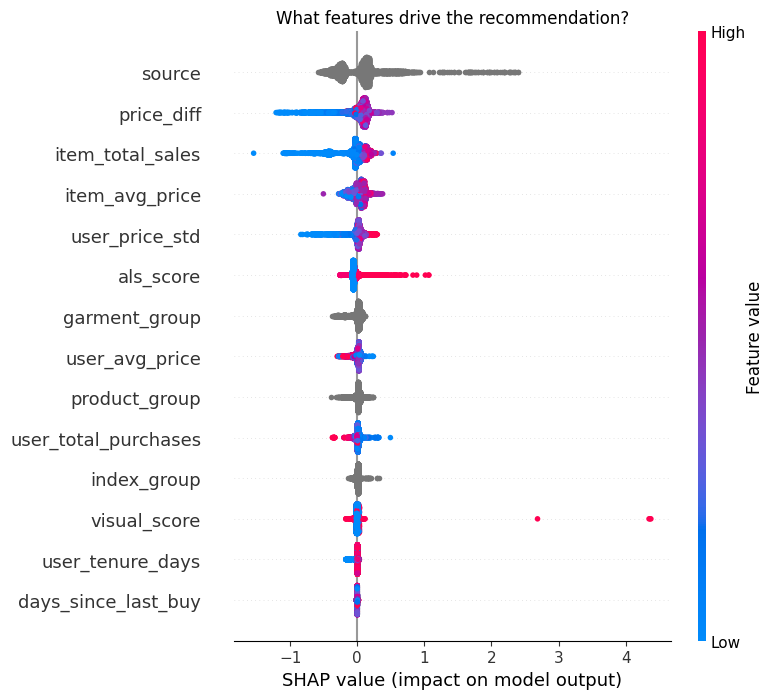

   Generating Dependence Plot...


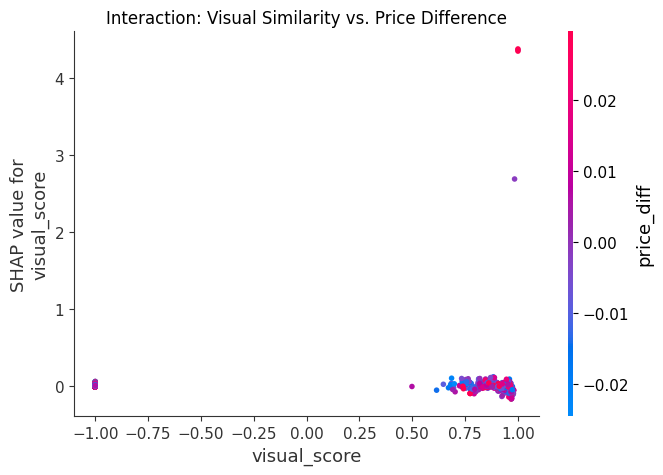

   Generating Waterfall Plot for a Top Prediction...


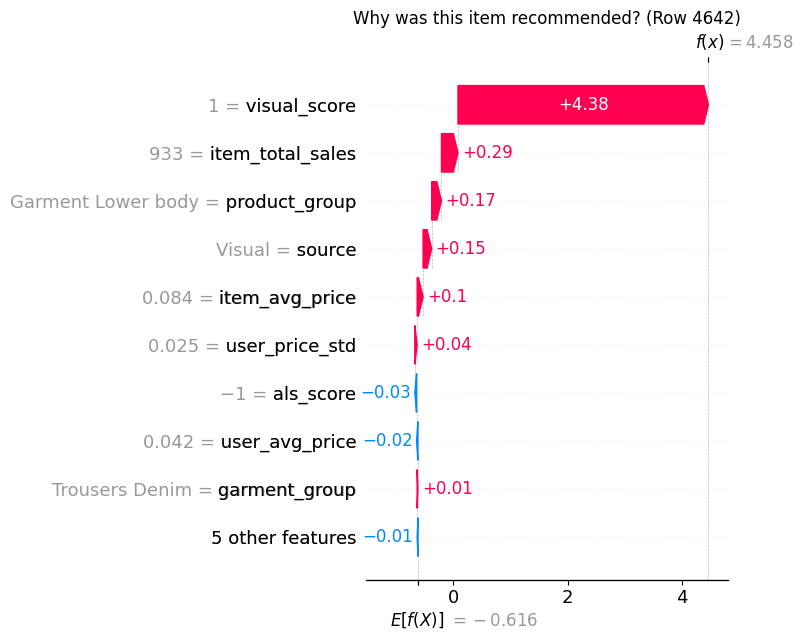

 Analysis Complete.


In [15]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import duckdb

print(" Starting Comprehensive SHAP Analysis...")

# --- 1. Load Data & Model ---
ranker = lgb.Booster(model_file='lgbm_ranker.model')
df = pd.read_parquet('train_data_full.parquet')

# Preprocessing
if df['source'].dtype == 'object' or df['source'].dtype.name == 'category':
    df['source'] = df['source'].astype('category').cat.codes
df['als_score'] = df['als_score'].fillna(-1)
df['visual_score'] = df['visual_score'].fillna(-1)

# Prepare Features
features_to_drop = ['customer_id_int', 'article_id_int', 'bought']
features = [c for c in df.columns if c not in features_to_drop]
X = df[features]

# --- 2. Create the "Display" Dataset ---
print("   Creating readable feature names for plots...")
SAMPLE_SIZE = 5000
X_sample = X.sample(SAMPLE_SIZE, random_state=42)
X_display = X_sample.copy()

# A. Map 'source' back to strings
source_map = {0: 'ALS', 1: 'Bestseller', 2: 'Repurchase', 3: 'Visual'}
X_display['source'] = X_display['source'].map(source_map)

# B. Map Categorical Groups back to Text (FIXED QUERY)
con = duckdb.connect("hm_fashion.duckdb", read_only=True)
sample_indices = X_sample.index
sample_article_ids = df.loc[sample_indices, 'article_id_int'].unique().tolist()

print("   Fetching metadata from DuckDB...")
# FIX: We join 'article_map' (m) to link the Integer ID to the Metadata (a)
metadata = con.execute(f"""
    SELECT 
        m.article_id_int, 
        a.product_group_name, 
        a.index_group_name, 
        a.garment_group_name
    FROM article_map m
    JOIN articles a ON m.article_id_str = a.article_id
    WHERE m.article_id_int IN ({','.join(map(str, sample_article_ids))})
""").df()

# Join metadata to X_display
X_display['article_id_int'] = df.loc[sample_indices, 'article_id_int']
X_display = X_display.merge(metadata, on='article_id_int', how='left')

# Replace the integer columns with the string names
X_display['product_group'] = X_display['product_group_name']
X_display['index_group'] = X_display['index_group_name']
X_display['garment_group'] = X_display['garment_group_name']

# Drop helper columns
X_display = X_display.drop(columns=['article_id_int', 'product_group_name', 'index_group_name', 'garment_group_name'])

print("   Display data ready.")

# --- 3. Calculate SHAP Values ---
print("   Calculating SHAP values (TreeExplainer)...")
explainer = shap.TreeExplainer(ranker)
shap_values = explainer.shap_values(X_sample)

# --- 4. Generate Plots ---

# A. Summary Plot (The Beeswarm)
plt.figure(figsize=(12, 8))
plt.title("What features drive the recommendation?")
shap.summary_plot(shap_values, X_display, show=False)
plt.tight_layout()
plt.show()

# B. Dependence Plot
print("   Generating Dependence Plot...")
shap.dependence_plot(
    "visual_score", 
    shap_values, 
    X_sample, 
    interaction_index="price_diff",
    show=False
)
plt.title("Interaction: Visual Similarity vs. Price Difference")
plt.show()

# C. Waterfall Plot
print("   Generating Waterfall Plot for a Top Prediction...")
prediction_sums = np.sum(shap_values, axis=1)
top_index = np.argmax(prediction_sums)

plt.figure(figsize=(10, 6))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[top_index], 
        base_values=explainer.expected_value, 
        data=X_display.iloc[top_index],
        feature_names=X_display.columns
    ),
    max_display=10,
    show=False
)
plt.title(f"Why was this item recommended? (Row {top_index})")
plt.tight_layout()
plt.show()

print(" Analysis Complete.")

In [16]:
import lightgbm as lgb
import pandas as pd
import duckdb
import pickle
import shutil
import os

print(" Packaging Model for Deployment...")

# 1. Create Artifact Directory
os.makedirs("deployment_artifacts", exist_ok=True)

# 2. Save the LightGBM Model (The Brain)
# We reload it to ensure it's the latest version, then save as text
ranker = lgb.Booster(model_file='lgbm_ranker.model')
ranker.save_model("deployment_artifacts/lgbm_ranker.txt")
print("   - Model saved.")

# 3. Save Visual Search Files (The Eyes)
# We copy them directly
shutil.copy("hm_visual.index", "deployment_artifacts/hm_visual.index")
shutil.copy("visual_index_map.pkl", "deployment_artifacts/visual_index_map.pkl")
print("   - Visual Index saved.")

# 4. Save "Feature Lookups" (The Memory)
# Instead of the full DB, we save small Parquet files for fast lookup.
con = duckdb.connect("hm_fashion.duckdb", read_only=True)

print("   - Exporting Feature Tables...")
# User Features (Price sensitivity, etc.)
con.execute("COPY (SELECT * FROM 'features_user.parquet') TO 'deployment_artifacts/features_user.parquet' (FORMAT PARQUET)")
# Item Features (Garment groups, etc.)
con.execute("COPY (SELECT * FROM 'features_item.parquet') TO 'deployment_artifacts/features_item.parquet' (FORMAT PARQUET)")
# Article Map (Int -> String ID)
con.execute("COPY (SELECT * FROM article_map) TO 'deployment_artifacts/article_map.parquet' (FORMAT PARQUET)")
# Active Articles (The list of items we can recommend) - Top 5000 popular items to save space/time for demo
con.execute("""
    COPY (
        SELECT article_id_int FROM item_features 
        ORDER BY item_total_sales DESC LIMIT 5000
    ) TO 'deployment_artifacts/candidates_pool.parquet' (FORMAT PARQUET)
""")

print("✅ Deployment Artifacts Ready in '/deployment_artifacts' folder.")

 Packaging Model for Deployment...
   - Model saved.
   - Visual Index saved.
   - Exporting Feature Tables...
✅ Deployment Artifacts Ready in '/deployment_artifacts' folder.
